In [47]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [48]:
mnist_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=mnist_transform, download=True
)

In [49]:
def showImageList(images):
    # show images side by side
    fig = plt.figure(figsize=(20, 5))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i  + 1)
        ax.axis("off")
        ax.imshow(image.squeeze(), cmap="gray", vmin=0, vmax=1)

In [34]:
H = 32
t = 0.75
t_scheduled = t ** (1 / 2)
int(H * (1 - t_scheduled) + 2 * t_scheduled)

6

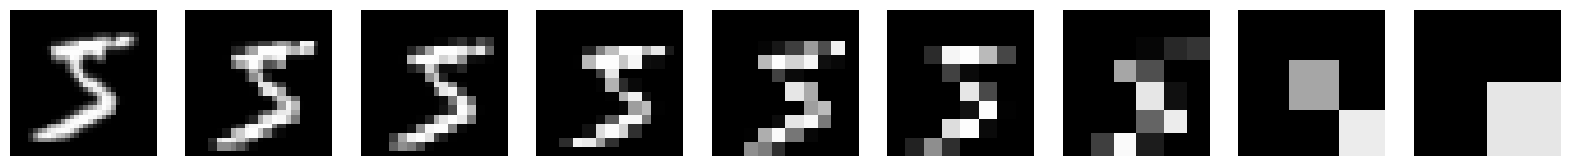

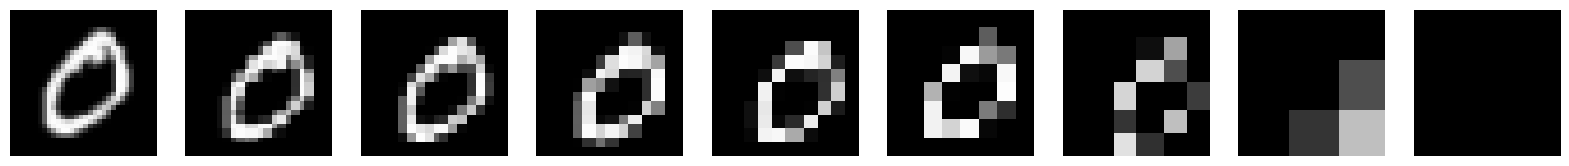

In [46]:
import torch.nn.functional as F


def pixelate(img_tensor, t):    
    # Calculate the reduced resolution
    C, H, W = img_tensor.shape

    # Calculate new size based on t
    t_scheduled = t ** (1 / 2)
    new_size = int(H * (1 - t_scheduled) + 2 * t_scheduled)

    # Resize down (pixelate)
    small_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(new_size, new_size), mode="nearest")

    # Resize back up
    return F.interpolate(small_tensor, size=(H, W), mode='nearest').squeeze(0)

test_image = train_dataset[4][0]

T = 8

for i in range(2):
    showImageList([
        pixelate(train_dataset[i][0], t/T) for t in range(0, T + 1)
    ])

In [53]:
T

44

In [68]:
1 // (10 + 1)

0

In [70]:
32 // (2 ** (0
             ))

16

16 32 0.9090909090909091
16 32 0.8181818181818182
16 32 0.7272727272727273
16 32 0.6363636363636364
16 32 0.5454545454545454
16 32 0.45454545454545453
16 32 0.36363636363636365
16 32 0.2727272727272727
16 32 0.18181818181818182
16 32 0.09090909090909091
8 16 0.9090909090909091
8 16 0.8181818181818182
8 16 0.7272727272727273
8 16 0.6363636363636364
8 16 0.5454545454545454
8 16 0.45454545454545453
8 16 0.36363636363636365
8 16 0.2727272727272727
8 16 0.18181818181818182
8 16 0.09090909090909091
4 8 0.9090909090909091
4 8 0.8181818181818182
4 8 0.7272727272727273
4 8 0.6363636363636364
4 8 0.5454545454545454
4 8 0.45454545454545453
4 8 0.36363636363636365
4 8 0.2727272727272727
4 8 0.18181818181818182
4 8 0.09090909090909091


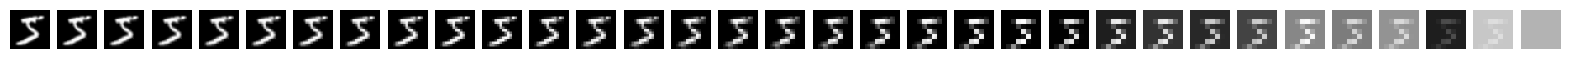

In [114]:
class Pixelate:
    def __init__(self, n_between: int = 1):
        self.n_between = n_between
        self.interpolation = transforms.InterpolationMode.NEAREST

    def calculate_T(self, image_size):
        """
        img0 -> img1/N -> img2/N -> .. -> img(N-1)/N -> img1 -> img(N+1)/N ->... imgK
        Where a fractional image denotes an interpolation between two images (imgA and img(A+1))
        """
        size = image_size
        count = 0
        while size > 4:
            count += 1
            size //= 2
        return count * (self.n_between + 1) - 1

    def set_image_to_random_grey(self, image: torch.Tensor):
        return image * 0 + torch.rand(1).to(image.device)

    def __call__(self, image: torch.Tensor, t: int):
        """
        t = 0 -> no pixelation
        t = T -> full pixelations
        """
        if isinstance(t, torch.Tensor):
            t = t.item()
        image_size = image.shape[-1]
        T = self.calculate_T(image_size)

        from_index = t // (self.n_between + 1)
        interpolation = ((self.n_between - t) % (self.n_between + 1)) / (self.n_between + 1)

        from_size = image_size // (2 ** (from_index + 1))

        if from_size <= 4:
            from_image = self.set_image_to_random_grey(image)
        else:
            from_transform = transforms.Compose(
                [
                    transforms.Resize(from_size, self.interpolation),
                    transforms.Resize(image_size, self.interpolation),
                ]
            )
            from_image = from_transform(image)

        if interpolation == 0:
            return from_image
        else:
            to_size = image_size // (2**(from_index))
            
            to_transform = transforms.Compose(
                [
                    transforms.Resize(to_size, self.interpolation),
                    transforms.Resize(image_size, self.interpolation),
                ]
            )
        
            to_image = to_transform(image)

            return (1 - interpolation) * from_image + interpolation * to_image
        
pixelate = Pixelate(10)

T = pixelate.calculate_T(32)

for i in range(1):
    showImageList([
        pixelate(train_dataset[i][0], t) for t in range(0, T + 1)
    ])

16 32 0.9090909090909091
16 32 0.8181818181818182
16 32 0.7272727272727273
16 32 0.6363636363636364
16 32 0.5454545454545454
16 32 0.45454545454545453
16 32 0.36363636363636365
16 32 0.2727272727272727
16 32 0.18181818181818182
16 32 0.09090909090909091
8 16 0.9090909090909091
8 16 0.8181818181818182
8 16 0.7272727272727273
8 16 0.6363636363636364
8 16 0.5454545454545454
8 16 0.45454545454545453
8 16 0.36363636363636365
8 16 0.2727272727272727
8 16 0.18181818181818182
8 16 0.09090909090909091
32 8 0.9090909090909091
32 8 0.8181818181818182
32 8 0.7272727272727273
32 8 0.6363636363636364
32 8 0.5454545454545454
32 8 0.45454545454545453
32 8 0.36363636363636365
32 8 0.2727272727272727
32 8 0.18181818181818182
32 8 0.09090909090909091


33

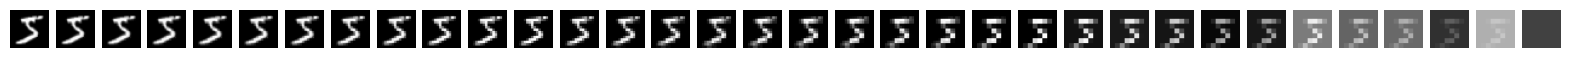

In [112]:
class Pixelate:
    def __init__(self, image_size, n_between: int = 1):
        """Sizes is a list of ints from smallest to largest"""
        self.sizes = self._calculate_sizes(image_size)
        self.transforms = [self.set_image_to_random_grey]
        interpolation = transforms.InterpolationMode.NEAREST
        for size in self.sizes:
            self.transforms.append(
                transforms.Compose(
                    [
                        transforms.Resize(size, interpolation),
                        transforms.Resize(self.sizes[-1], interpolation),
                    ]
                )
            )
        self.n_between = n_between
        self.T = self.calculate_T()

    def _calculate_sizes(self, image_size):
        # Double the size until we reach the image size
        result = []
        n = 8
        while n <= image_size:
            result.append(n)
            n *= 2
        return result

    def calculate_T(self):
        """
        img0 -> img1/N -> img2/N -> .. -> img(N-1)/N -> img1 -> img(N+1)/N ->... imgK
        Where a fractional image denotes a interpolation between two images (imgA and img(A+1))
        The number of images in the above becomes (excluding the original image):
        K * (N+1)
        """
        return len(self.sizes) * (self.n_between + 1)

    def set_image_to_random_grey(self, image: torch.Tensor):
        return image * 0 + torch.rand(1).to(image.device)

    def __call__(self, image: torch.Tensor, t: int):
        """
        t = 0 -> no pixelation
        t = T -> full pixelations
        """
        fromIndex = (self.T - t) // (self.n_between + 1)
        interpolation = ((self.T - t) % (self.n_between + 1)) / (self.n_between + 1)
        fromImage = self.transforms[fromIndex](image)
        if interpolation == 0:
            return fromImage
        else:
            toIndex = fromIndex + 1
            toImage = self.transforms[toIndex](image)
            print(self.sizes[fromIndex-1], self.sizes[toIndex-1], interpolation)
            return (1 - interpolation) * fromImage + interpolation * toImage

        
pixelate = Pixelate(32, 10)

T = pixelate.calculate_T()

for i in range(1):
    showImageList([
        pixelate(train_dataset[i][0], t) for t in range(0, T + 1)
    ])

/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_73358/210128208.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20, 5))


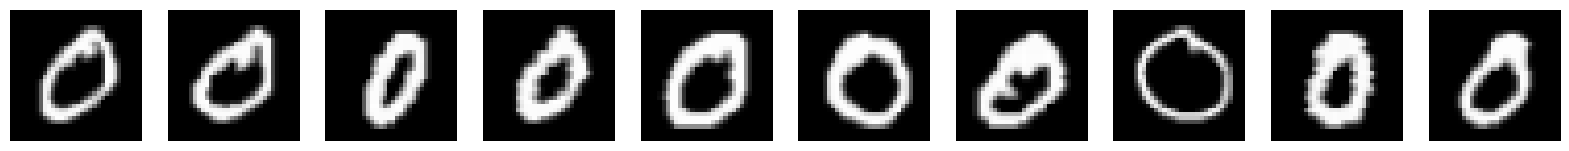

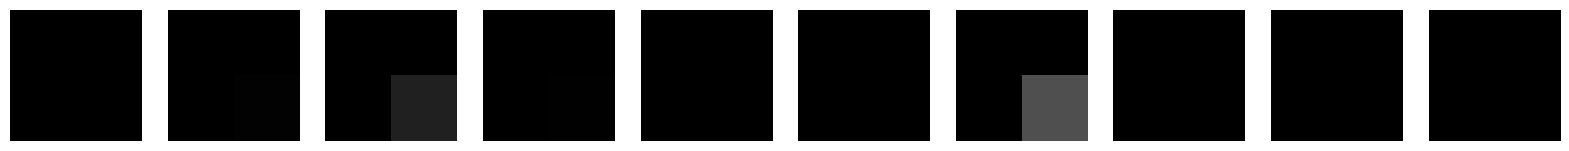

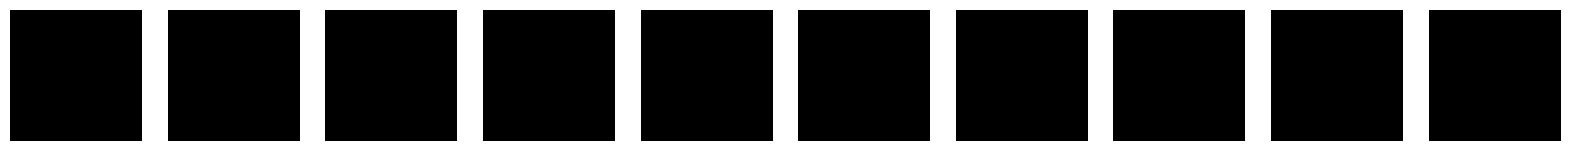

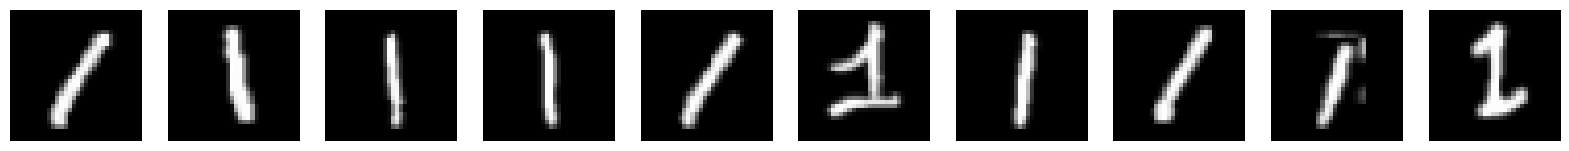

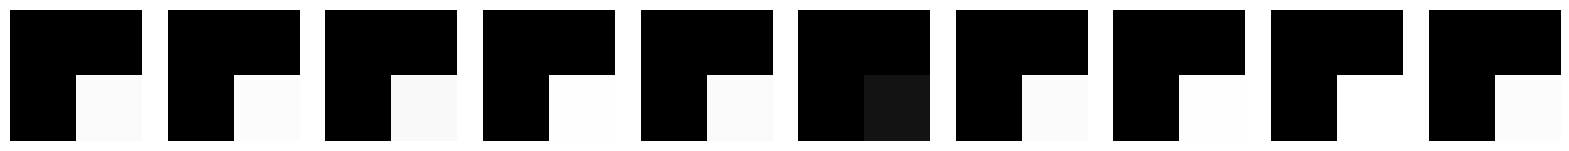

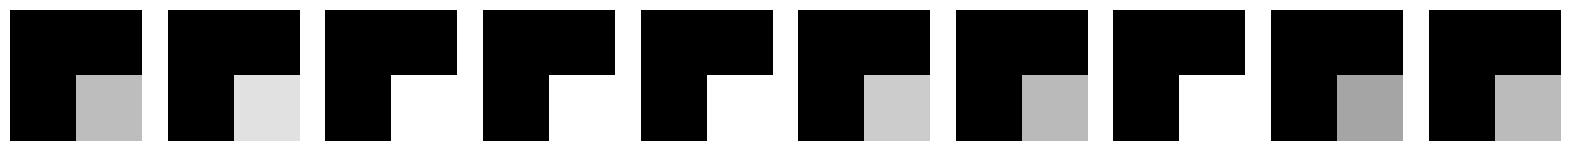

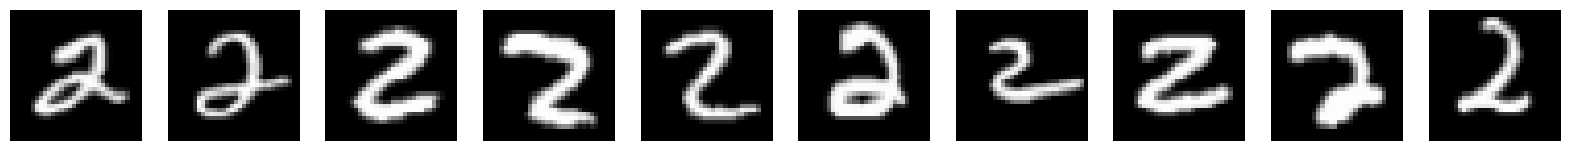

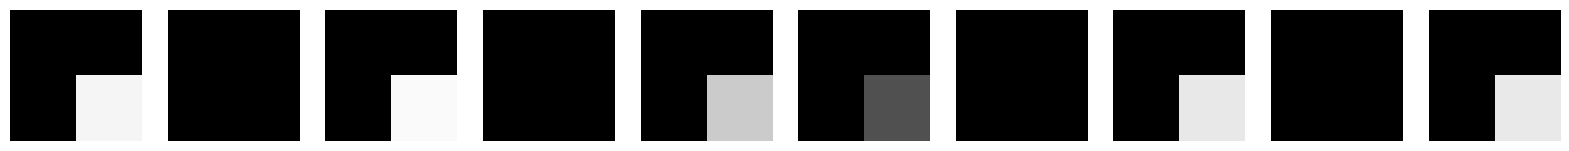

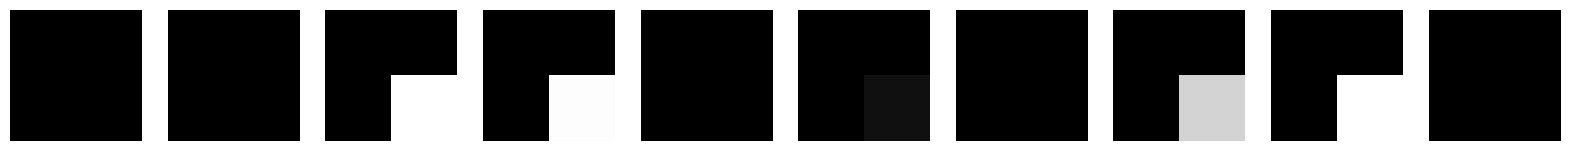

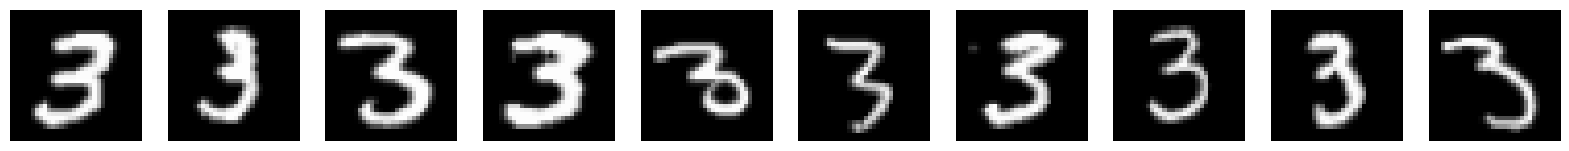

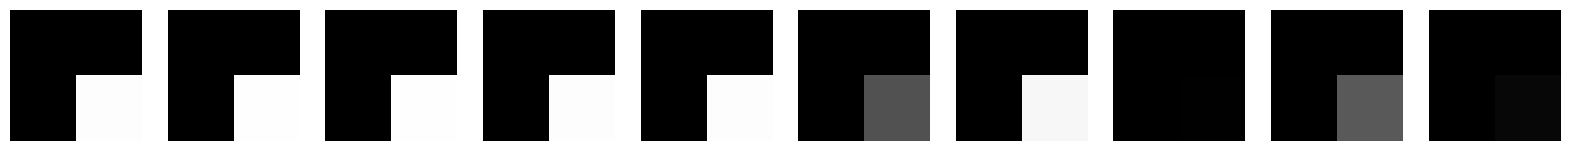

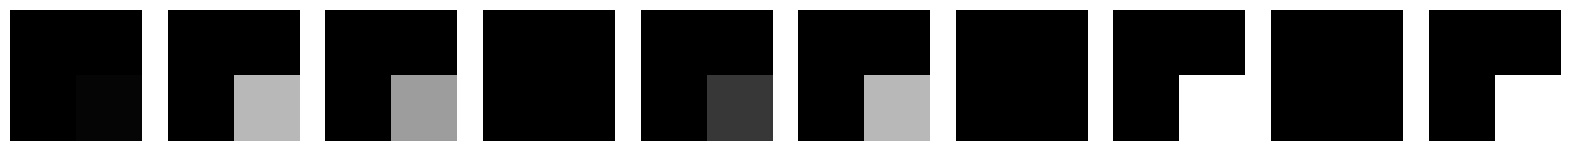

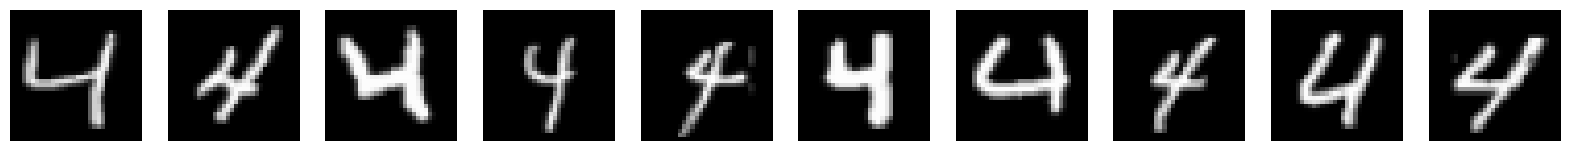

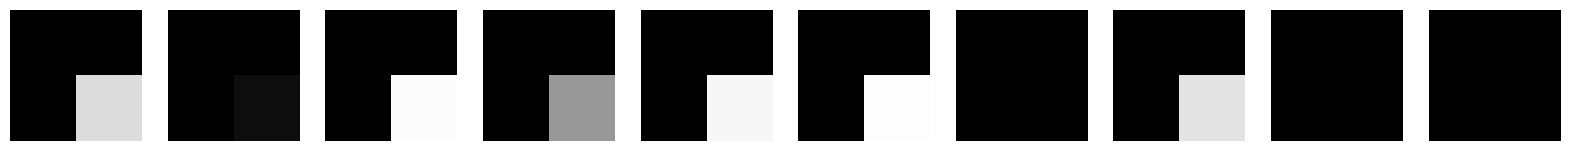

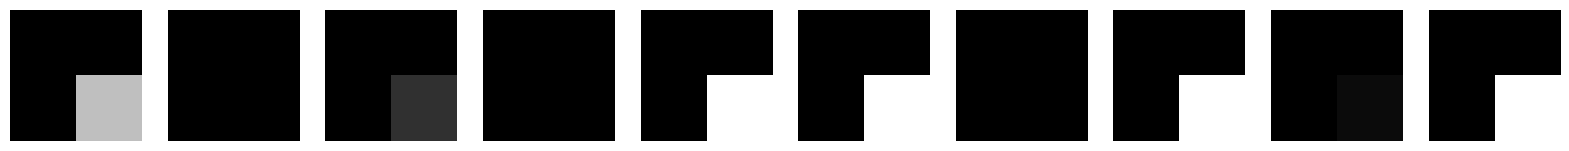

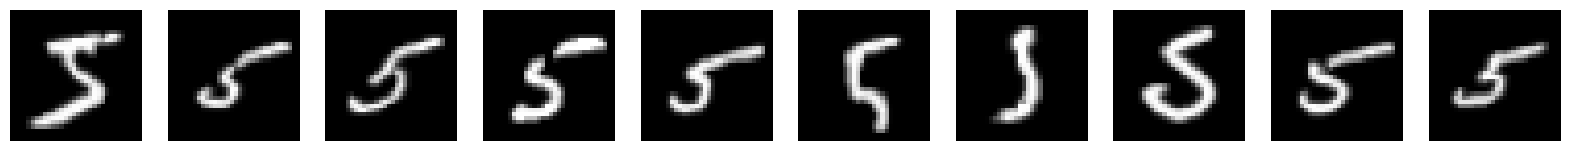

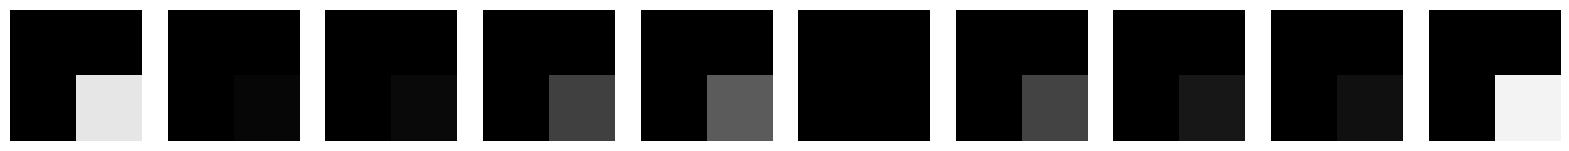

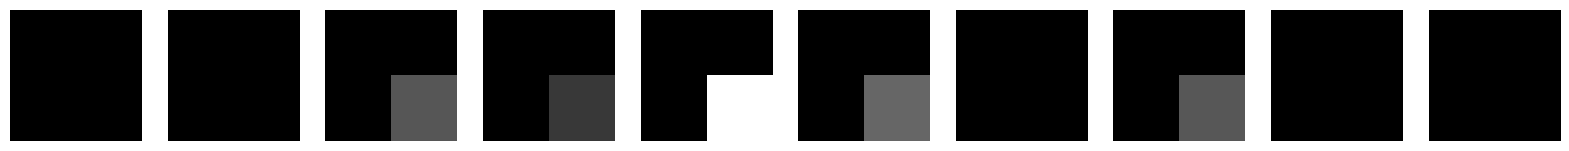

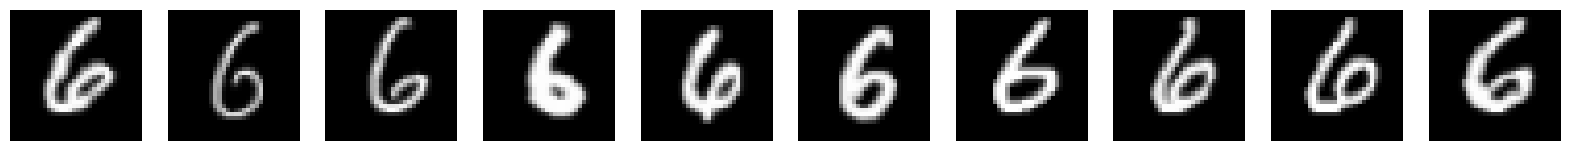

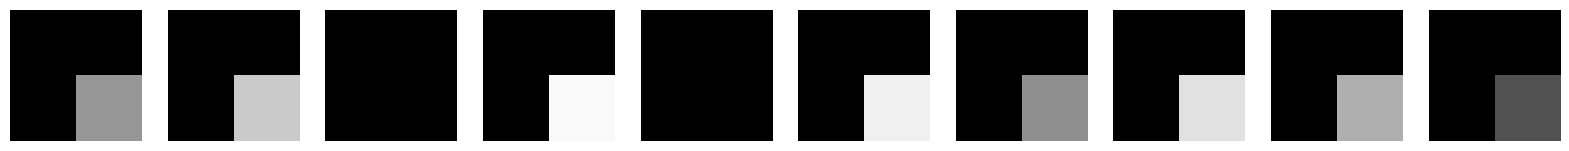

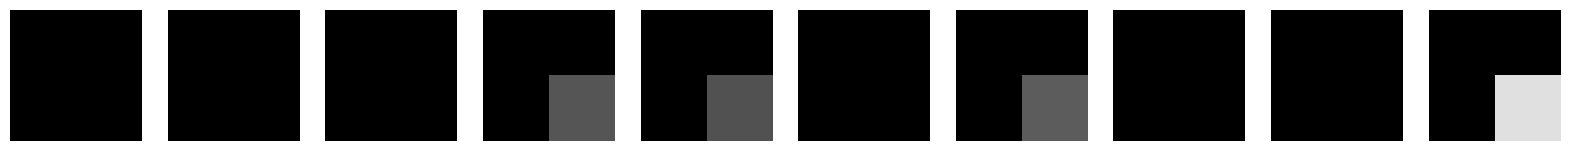

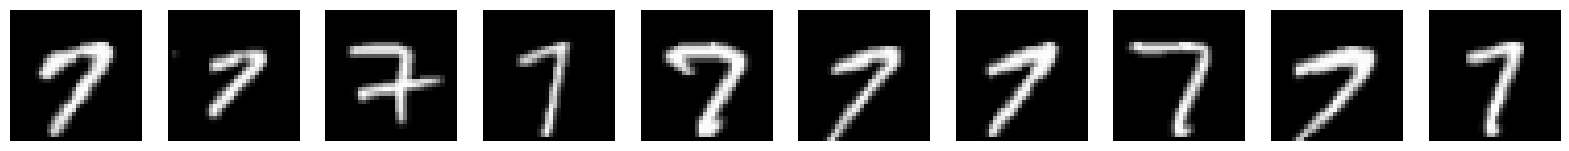

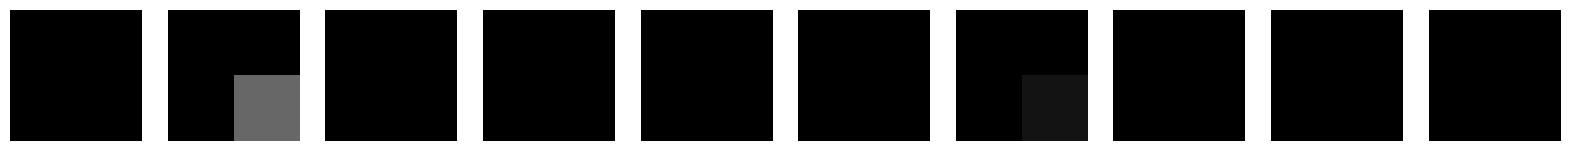

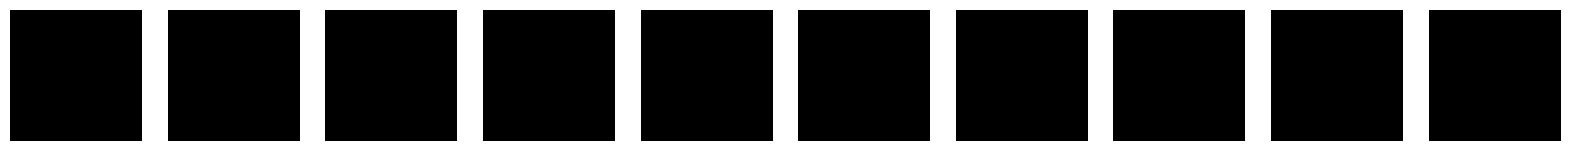

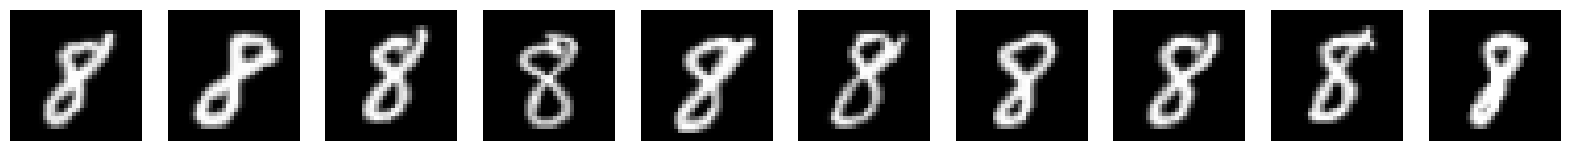

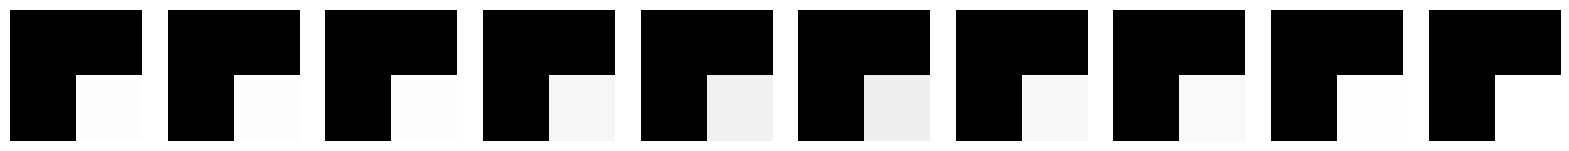

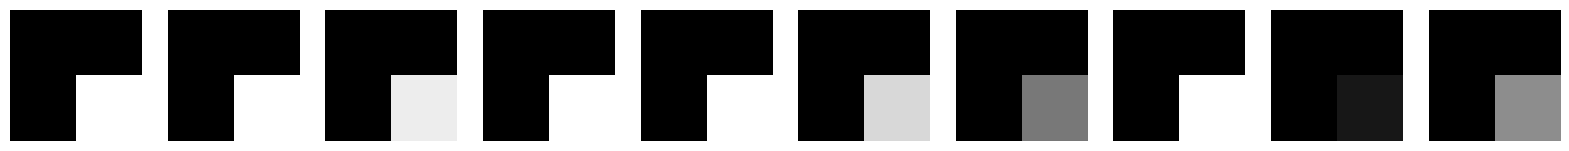

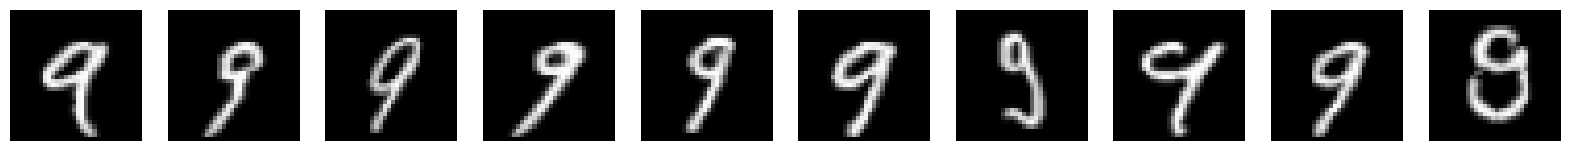

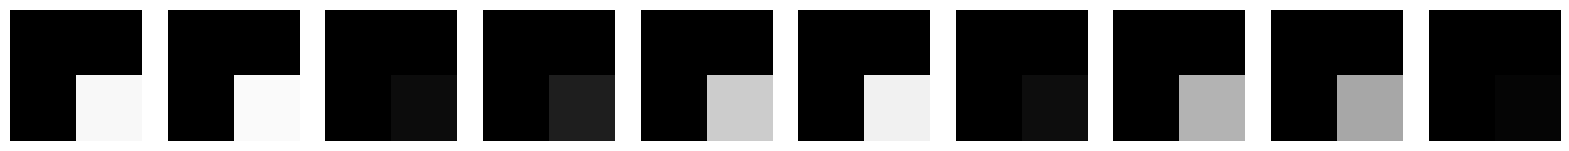

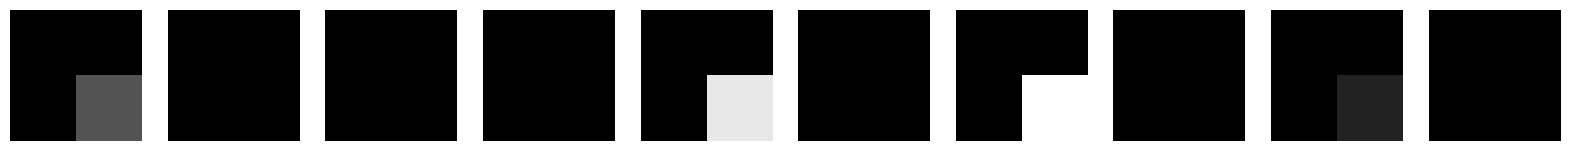

In [16]:
from model import GMMInitializer
import gmm

# Show n fully pixelated images of each digit
n = 10
gmm_model = gmm.load_gmm_model('models/gmm_model.pkl')
gmm_initializer = GMMInitializer(gmm_model)

    
for digit in range(10):
    original = []
    pixelated = []
    samples = gmm_initializer.sample(n, size=(32, 32), label=digit)
    
    i = 0
    while len(pixelated) < n:
        if train_dataset[i][1] == digit:
            original.append(train_dataset[i][0])
            pixelated.append(pixelate(train_dataset[i][0], T))
        i += 1
    showImageList(original)
    showImageList(pixelated)
    showImageList(samples)

In [1]:
import random

def generate_tensor(image_size=32):
    """Generate 32x32 tensor with 9 big square random hues of black/white/grey."""
    tensor = torch.zeros((image_size, image_size))

    block_size = image_size // 2

    def skewed_random():
        """Generate a random value skewed towards 0 or 1."""
        rand_val = torch.rand(1).item()
        return rand_val ** 5

    # Loop over the tensor in 10x10 chunks
    for i in range(0, image_size, block_size):
        for j in range(0, image_size, block_size):
            tensor[i:i+block_size, j:j+block_size] = random.choices([0, 0.5, 1], [0.8, 0.1, 0.1], k=1)[0]

    return tensor

tensor = generate_tensor(image_size=16)
showImageList([tensor])

NameError: name 'torch' is not defined